In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import datetime
import math

In [3]:
#load datasets
am_df = pd.read_csv("data/american_stock.csv")
eu_df = pd.read_csv("data/european_index.csv")
rf_df = pd.read_csv("data/FEDFUNDS.csv")
stock_price_df = pd.read_csv("data/stock_prices.csv")

In [4]:
rf_df["DATE"] = pd.to_datetime(rf_df["DATE"], format="%Y-%m-%d")
rf_df.head()

,DATE,FEDFUNDS
0,2013-02-01,0.15
1,2013-03-01,0.14
2,2013-04-01,0.15
3,2013-05-01,0.11
4,2013-06-01,0.09


In [5]:
am_df = am_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
am_df["tte"] = am_df["exdate"] - am_df["date"]
am_df["rf_join_date"] = pd.to_datetime(am_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
am_df = pd.merge(am_df, rf_df, left_on="rf_join_date", right_on="DATE")
am_df.head()

/var/folders/77/q3gt76rs7s9dtwfn9frfxdfm0000gn/T/ipykernel_69197/1634286520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["date"] = pd.to_datetime(am_df["date"], format="%Y%m%d")
/var/folders/77/q3gt76rs7s9dtwfn9frfxdfm0000gn/T/ipykernel_69197/1634286520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_df["exdate"] = pd.to_datetime(am_df["exdate"], format="%Y%m%d")
/var/folders/77/q3gt76rs7s9dtwfn9frfxdfm0000gn/T/ipykernel_69197/1634286520.py:4: SettingWithCopyWarning: 
A value is trying t

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,rf_join_date,DATE,FEDFUNDS
0,2015-01-02,AAPL 150102C100000,2015-01-02,C,100000,9.20,9.35,A,0 days,2015-01-01,2015-01-01,0.11
1,2015-01-02,AAPL 150102C101000,2015-01-02,C,101000,8.20,8.40,A,0 days,2015-01-01,2015-01-01,0.11
2,2015-01-02,AAPL 150102C102000,2015-01-02,C,102000,7.25,7.35,A,0 days,2015-01-01,2015-01-01,0.11
3,2015-01-02,AAPL 150102C103000,2015-01-02,C,103000,6.20,6.40,A,0 days,2015-01-01,2015-01-01,0.11
4,2015-01-02,AAPL 150102C104000,2015-01-02,C,104000,5.25,5.35,A,0 days,2015-01-01,2015-01-01,0.11


In [6]:
eu_df = eu_df[["date", "symbol", "exdate", "cp_flag", "strike_price", "best_bid", "best_offer", "exercise_style"]]
eu_df["date"] = pd.to_datetime(eu_df["date"], format="%Y%m%d")
eu_df["exdate"] = pd.to_datetime(eu_df["exdate"], format="%Y%m%d")
eu_df["tte"] = eu_df["exdate"] - eu_df["date"]
eu_df["rf_join_date"] = pd.to_datetime(eu_df["date"].apply(lambda x: datetime.date(x.year, x.month, 1)))
eu_df = pd.merge(eu_df, rf_df, left_on="rf_join_date", right_on="DATE")
eu_df.head()

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,tte,rf_join_date,DATE,FEDFUNDS
0,2015-01-02,NDX 150109C3100000,2015-01-09,C,3100000,1124.9,1134.0,E,7 days,2015-01-01,2015-01-01,0.11
1,2015-01-02,NDX 150109C3125000,2015-01-09,C,3125000,1099.9,1109.0,E,7 days,2015-01-01,2015-01-01,0.11
2,2015-01-02,NDX 150109C3150000,2015-01-09,C,3150000,1074.9,1084.0,E,7 days,2015-01-01,2015-01-01,0.11
3,2015-01-02,NDX 150109C3175000,2015-01-09,C,3175000,1049.9,1059.0,E,7 days,2015-01-01,2015-01-01,0.11
4,2015-01-02,NDX 150109C3200000,2015-01-09,C,3200000,1024.9,1034.0,E,7 days,2015-01-01,2015-01-01,0.11


In [12]:
stock_price_df[stock_price_df["tic"] == "AAPL"]

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,iid,datadate,...,dvi,eps,epsmo,prccd,prchd,prcld,prcod,prcstd,trfd,ccmbegdt
0,1690,P,1,LU,14593,7,19801212,E,1,20100104,...,0.00,6.39,9,214.01,214.5000,212.3800,213.430,3,1.095663,20090201
1,1690,P,1,LU,14593,7,19801212,E,1,20100105,...,0.00,6.39,9,214.38,215.5900,213.2500,214.600,3,1.095663,20090201
2,1690,P,1,LU,14593,7,19801212,E,1,20100106,...,0.00,6.39,9,210.97,215.2300,210.7500,214.380,3,1.095663,20090201
3,1690,P,1,LU,14593,7,19801212,E,1,20100107,...,0.00,6.39,9,210.58,212.0000,209.0500,211.750,3,1.095663,20090201
4,1690,P,1,LU,14593,7,19801212,E,1,20100108,...,0.00,6.39,9,211.98,212.0000,209.0600,210.300,3,1.095663,20090201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3314,1690,P,1,LU,14593,7,19801212,E,1,20230306,...,0.92,5.93,12,153.83,156.3000,153.4600,153.785,3,1.287473,20220401
3315,1690,P,1,LU,14593,7,19801212,E,1,20230307,...,0.92,5.93,12,151.60,154.0299,151.1300,153.700,3,1.287473,20220401
3316,1690,P,1,LU,14593,7,19801212,E,1,20230308,...,0.92,5.93,12,152.87,153.4700,151.8300,152.810,3,1.287473,20220401
3317,1690,P,1,LU,14593,7,19801212,E,1,20230309,...,0.92,5.93,12,150.59,154.5350,150.2250,153.559,3,1.287473,20220401


In [16]:
display(eu_df)

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag
0,102480,20150102,NDX 150109C3100000,1,20150109,20141230.0,C,3100000,1124.9,1134.0,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
1,102480,20150102,NDX 150109C3125000,1,20150109,NaN,C,3125000,1099.9,1109.0,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
2,102480,20150102,NDX 150109C3150000,1,20150109,NaN,C,3150000,1074.9,1084.0,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
3,102480,20150102,NDX 150109C3175000,1,20150109,NaN,C,3175000,1049.9,1059.0,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
4,102480,20150102,NDX 150109C3200000,1,20150109,NaN,C,3200000,1024.9,1034.0,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12242381,102480,20211231,NDXP 220225P21100000,1,20220225,NaN,P,21100000,4756.6,4787.8,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
12242382,102480,20211231,NDXP 220225P21200000,1,20220225,NaN,P,21200000,4856.4,4883.9,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
12242383,102480,20211231,NDXP 220225P21300000,1,20220225,NaN,P,21300000,4956.3,4985.3,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN
12242384,102480,20211231,NDXP 220225P21400000,1,20220225,NaN,P,21400000,5056.1,5087.4,...,9999,1,32768,NaN,A,NaN,NASDAQ 100 INDEX,I,E,NaN


In [16]:
# European Options Pricing Monte Carlo Simulation assuming log-normal distribution of stock, e.g. SPX.
# Larger the num_simulations, the more accurate the model becomes, at square root scale
# Default number is 100,000 simulations
def monte_carlo_european_option_pricing(init_price, strike, ttm, int_rate, volatility, type_of_option='call', num_simulations=100000, num_plotted_paths = 10):
    """
    Monte Carlo pricing model for European options.

    :param init_price: Initial stock price
    :param strike: Strike price
    :param ttm: Time to maturity (in years)
    :param int_rate: Risk-free interest rate
    :param volatility: Volatility of the underlying asset
    :param type_of_option: Type of option ('call' or 'put')
    :param num_simulations: Number of simulations for Monte Carlo
    :param num_of_plotted_paths : Number of these random log-normal distribution paths to plot
    :return: The estimated price of the option
    """

    # Generate random numbers for the Monte Carlo simulation (decided to use normal distribution for this since it's clean)
    rand_nums = np.random.standard_normal(size=(num_plotted_paths, num_simulations))

    # Calculate the stock price at maturity for each simulation (S(t) from the textbook)
    # Used Geometric Brownian Motion assuming the stock follows log-normal distribution
    price_at_maturity = init_price * np.exp((int_rate - 0.5 * volatility ** 2) * ttm + volatility * math.sqrt(ttm) * rand_nums)

    plt.figure(figsize=(10, 6))
    time_steps = np.linspace(0, ttm, num_simulations)
    for i in range(num_plotted_paths):
        plt.plot(time_steps,
                 init_price *
                 np.exp((int_rate - 0.5 * volatility ** 2) *
                        time_steps +
                        sigma * math.sqrt(ttm) * rand_nums[i, :]))
    plt.xlabel('Time (years)')
    plt.ylabel('Stock Price')
    plt.title('Sample Stock Price Paths')
    plt.grid(True)
    plt.show()

    # Determine the payoff for each simulation type (call or put)
    if type_of_option.lower() == 'call':
        payoff = np.maximum(price_at_maturity[:, -1] - strike, 0)
    elif type_of_option.lower() == 'put':
        payoff = np.maximum(strike - price_at_maturity[:, -1], 0)
    # This scenario shouldn't happen if the user doesn't violate the invariant of our function
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

    # Calculate the present value of the payoffs using interest rate
    present_value = np.exp(-int_rate * ttm) * payoff

    # Estimate the option price as the mean of the present values of all of our simulations
    final_price = np.mean(present_value)

    return final_price


#TODO: Add matplotlib graphs & backtest against common European options like SPX by parsing the dataframes for the data we need


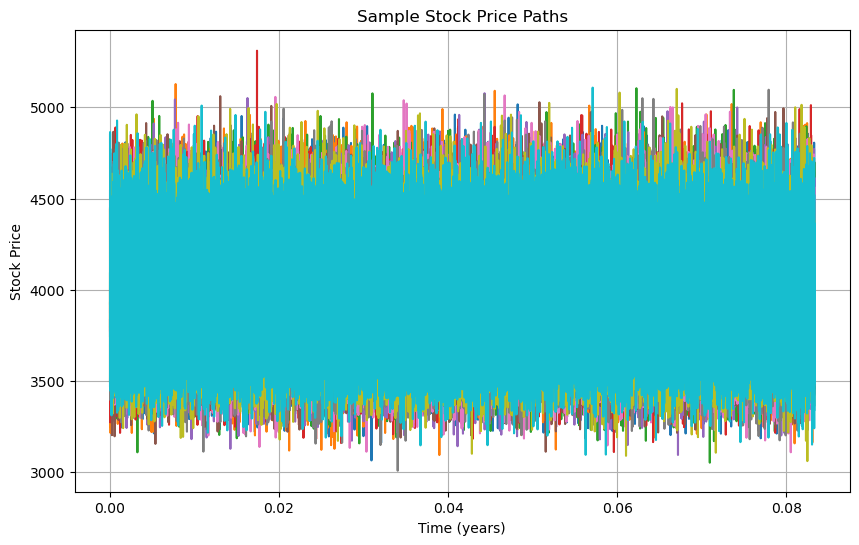

The estimated price of the European put for SPX put expiring in 1 month is $89.13


In [17]:
# Example usage with a random SPX options contract currently
S0 = 3970.99          # Initial stock price
K = 3925.00           # Strike price
T = (1/12)            # Time to maturity (in years)
r = 0.0338            # Risk-free interest rate
sigma = 0.2012        # Volatility of the underlying asset
option_type = 'put'

option_price = monte_carlo_european_option_pricing(S0, K, T, r, sigma, option_type)
print(f"The estimated price of the European {option_type} for SPX put expiring in 1 month is ${option_price:.2f}")


In [6]:
# Least Squares Monte Carlo Algorithm For Pricing American Options, e.g. SPY/AAPL

def generate_random_paths(u_price, int_rate, volatility, ttm, time_step, n_paths):
    """
    Generates 2D random path using Geometric Brownian Motion (a stochastic process, read up here: bit.ly/3KaOTlk) to simulate random price paths
    :param u_price: Initial underlying price of asset at option contract creation
    :param int_rate: Risk free interest rate investor earns on any risk-free asset during same time as option
    :param volatility: Volatility, or degree of fluctuations over the time period
    :param ttm : Time until option maturity/expiration
    :param time_step: The fraction of a year used as a singular time step in the LSM Simulation
    :param n_paths: Number of simulated path prices/trajectories for our option
    :return: S, A 2-dimensional numpy array where the [cols] are paths and [rows] are time stamps
    """
    # Find number of steps for simulation based on ttm and time step
    n_steps = math.ceil(ttm/time_step)
    # Make random increments for our paths (2D array of normal increments with mean 0 and std deviation equal to sqrt of time_step
    # Dimensions of resulting random array: (N_steps, N_paths):
    random_increments = np.random.normal(0, np.sqrt(time_step), (n_steps, n_paths))
    # Sum up these random increments along the time step axis, which we mark as 0 for now
    sum_random_increments = np.cumsum(random_increments, axis=0)
    # Use Geometric Brownian Motion formula to calculate the final paths and time stamps
    return u_price * np.exp((int_rate - 0.5 * volatility ** 2) * np.linspace(time_step, ttm, n_steps)[:, np.newaxis] + volatility * sum_random_increments)

#TODO: Implement the American Model and iterate through all time steps to find which ones have positive intrinsic value
#TODO: Add matplotlib graphs & backtest against common American options like SPY and AAPL


In [ ]:
#TODO: Add some test cases